# Use case 4: corner reflector

This section explains how to identify bursts in which the corner reflector (CR), having known geodetic coordinates, is visible, and how to get corrections at CR location.

## Notebook setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import numpy as np
from scipy.interpolate import interp2d
from matplotlib import pyplot as plt

In [4]:
import s1etad
from s1etad import Sentinel1Etad, ECorrectionType

## Searching bursts in which the CR is present

Load the S1-ETAD product.

In [5]:
filename = '../../sample-products/S1B_IW_ETA__AXDV_20190805T162509_20190805T162536_017453_020D3A_____.SAFE'
eta = Sentinel1Etad(filename)

The CR position has been chosed to be in the overlab region of different bursts and swaths.

In [6]:
from shapely.geometry import Point

lat0 = 46.47
lon0 = 22.24

cr = Point(lon0, lat0)

Query for burst cobering the CR.

In [7]:
selection = eta.query_burst(geometry=cr)
selection

,bIndex,pIndex,sIndex,productID,swathID,azimuthTimeMin,azimuthTimeMax
21,12,1,3,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW3,2019-08-05 16:25:19.995338,2019-08-05 16:25:23.189673
13,14,1,2,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW2,2019-08-05 16:25:21.808339,2019-08-05 16:25:24.973896
22,15,1,3,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW3,2019-08-05 16:25:22.758006,2019-08-05 16:25:25.952341


## Get corrections at CR location

Reatrieve the first burst.

In [8]:
burst = next(eta.iter_bursts(selection))

Get RADAR coordinates (range and azimuth time) of the CR.

In [9]:
tau0, t0 = burst.geodetic_to_radar(lat0, lon0)
tau0, t0

(array([0.0007055]), array([13.09657758]))

Get image coordinates (line and sample) of the CR.

**NOTE**: image coordinates area flaoting point numbers including pixel fractions.

In [10]:
line, sample = burst.radar_to_image(t0, tau0)
print(f'Line {line} of {burst.lines}, sample {sample} of {burst.samples}.')

Line [102.0932647] of 112, sample [30.99515762] of 502.


Get the correction.

In [11]:
correction = burst.get_correction(s1etad.ECorrectionType.SUM, meter='True')
data = correction['x']  # summ of corrections in the range direction

Interpolate the correction at the specified RADAR coordinates (tau0, t0).

In [12]:
azimuth_time, range_time = burst.get_burst_grid()

interpolator = interp2d(range_time, azimuth_time, data)

value_at_radar_coordinates = interpolator(tau0, t0)

print(f'The correction value at RADAR coordinates (tau0, t0) = ({tau0}, {t0}) is {value_at_radar_coordinates}')    

The correction value at RADAR coordinates (tau0, t0) = ([0.0007055], [13.09657758]) is [2.85881962]


Interpolate the correction at the specified image coordinates (line, sample).

In [13]:
xaxis = np.arange(burst.samples)
yaxis = np.arange(burst.lines)

interpolator = interp2d(xaxis, yaxis, data)

value_at_image_coordinates = interpolator(sample, line)

print(f'The correction value at image coordinates (sample, line) = ({sample}, {line}) is {value_at_image_coordinates}') 

The correction value at image coordinates (sample, line) = ([30.99515762], [102.0932647]) is [2.85881962]


## Putting all together

xy   IW3 12 [102.0932647] [30.99515762] (array([46.47]), array([22.24]), array([588.85315534]))
time IW3 12 [0.0007055] [13.09657758] (array([46.47]), array([22.24]), array([588.85315534]))
Interpoaltion by array coordinate [2.85881962] or time [2.85881962] should be the same
The total correction at lat/lon (46.47, 22.24) is  [2.85881962] m in range

xy   IW2 14 [39.0932647] [489.99515784] (array([46.47]), array([22.24]), array([588.85315975]))
time IW2 14 [0.0007055] [13.09657758] (array([46.47]), array([22.24]), array([588.85315975]))
Interpoaltion by array coordinate [3.37516011] or time [3.37516011] should be the same
The total correction at lat/lon (46.47, 22.24) is  [3.37516011] m in range

xy   IW3 15 [6.09326468] [30.99516845] (array([46.47]), array([22.24]), array([588.85274224]))
time IW3 15 [0.0007055] [13.09657758] (array([46.47]), array([22.24]), array([588.85274224]))
Interpoaltion by array coordinate [3.66446108] or time [3.66446108] should be the same
The total correcti

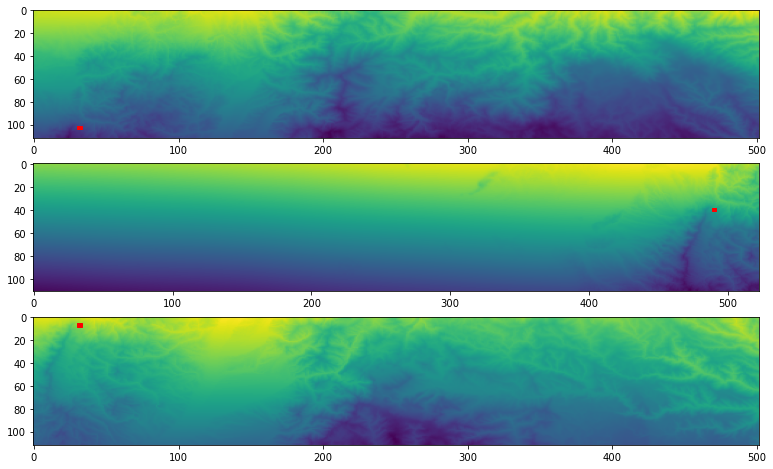

In [14]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(nrows=len(selection), ncols=1, figsize=[13, 8])

for loop, burst in enumerate(eta.iter_bursts(selection)):
    # get RADAR and image coordinates
    tau0, t0 = burst.geodetic_to_radar(lat0, lon0)
    line0, sample0 = burst.radar_to_image(t0, tau0)    
    print("xy  ", burst.swath_id, burst.burst_index, line0, sample0, burst.radar_to_geodetic(tau0, t0))
    print("time", burst.swath_id, burst.burst_index, tau0, t0, burst.radar_to_geodetic(tau0, t0))
    
    # correction
    cor = burst.get_correction(s1etad.ECorrectionType.SUM, meter='True')

    ax[loop].imshow(cor['x'], aspect='auto')
    rec_half_size = 1
    p = Rectangle((sample0 - rec_half_size, line0 - rec_half_size),
                  width=rec_half_size*2+1, height=rec_half_size*2+1,
                  color='red', fill=True)
    ax[loop].add_patch(p)

    # get the range and azimuth time axes
    azimuth_time, range_time = burst.get_burst_grid()

    # interpolate at the desired working (RADAR) coordinates
    f_t  = interp2d(range_time, azimuth_time, cor['x'])

    # get the image (lines and samples) axes
    yaxis = np.arange(azimuth_time.size)
    xaxis = np.arange(range_time.size)
    
    # interpolate at the desired working (image) coordinates
    f_ij = interp2d(xaxis, yaxis, cor['x'])
    
    print(f"Interpoaltion by array coordinate {f_ij(sample0, line0)} or time {f_t(tau0,t0)} should be the same")
    print(f"The total correction at lat/lon {lat0, lon0} is  {f_ij(sample0, line0)} m in range")
    print()

In [15]:
burst.radar_to_geodetic(tau0, t0) 

(array([46.47]), array([22.24]), array([588.85274224]))

In [16]:
cor

{'x': array([[3.82522036, 3.82434148, 3.83363703, ..., 3.5995925 , 3.62206981,
         3.63740414],
        [3.81676206, 3.8131126 , 3.82107175, ..., 3.58131523, 3.60370253,
         3.62208343],
        [3.80864289, 3.80436382, 3.8080162 , ..., 3.56824272, 3.58952984,
         3.6073659 ],
        ...,
        [2.89687749, 2.92200339, 2.92661081, ..., 2.96964387, 2.97884655,
         2.99675918],
        [2.90007085, 2.92202781, 2.90046293, ..., 2.98028671, 2.98631851,
         3.01383408],
        [2.91121219, 2.89186773, 2.88525785, ..., 3.00992875, 3.00509655,
         3.02659579]]),
 'y': array([[-0.89716198, -1.03873847, -0.83262693, ..., -3.77640932,
         -2.93655538, -2.29252647],
        [-0.80189366, -1.02411386, -0.88305598, ..., -4.06105331,
         -3.19947167, -2.44516834],
        [-0.73048383, -0.92705044, -0.91098543, ..., -4.23616619,
         -3.34657407, -2.53104979],
        ...,
        [ 0.36700151, -0.35895894, -0.57601863, ..., -1.56635072,
         -1.63